# Modulok és Dataprep

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [2]:
working_data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/ONKUTFEL2/NYERS_2021/data_2021_SZŰKJÓ.xlsx")

**Minimális Feature Engineering**

In [3]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = working_data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
#for i, row in working_data.iterrows():
#    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
#    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
#    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
#    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [4]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 3
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 3]:
        working_data.at[i, "Matematika A1a - Analízis"] = 2

In [5]:
working_data['Matematika A1a - Analízis'].value_counts()

2    97
3    54
1    51
Name: Matematika A1a - Analízis, dtype: int64

# Vegyészek

In [6]:
from imblearn.over_sampling import SMOTE



#smote = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = {2: 145, 3: 80, 1: 25})

vegyesz = working_data.query("Szak == 'Vegyészmérnöki'")

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = vegyesz.drop(labels = ["Matematika A1a - Analízis", "Szak", "Matek helyes","Kognitív pont", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = vegyesz["Matematika A1a - Analízis"]

#itt nem kell SMOTE
#features, label = smote.fit_resample(features, label)


X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(


## Osztályozó algoritmusok

**KNN**

In [7]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.6266666666666667, 'test_score': 0.71875}
Params:
{'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.45904762 0.45904762 0.45904762 0.53047619 0.45904762 0.45904762
 0.61333333 0.62666667 0.62666667 0.6        0.54380952 0.54380952
 0.5847619  0.54285714 0.55714286 0.61142857 0.57142857 0.58571429
 0.56952381 0.51428571 0.52857143 0.5552381  0.57047619 0.57047619
 0.55619048 0.55619048 0.55619048 0.58380952 0.54285714 0.54285714
 0.58380952 0.55619048 0.55619048 0.55619048 0.55714286 0.55714286
 0.59904762 0.59904762 0.59904762 0.58571429 0.57142857 0.57142857
 0.57047619 0.59904762 0.59904762 0.5847619  0.55619048 0.57047619
 0.57047619 0.5847619  0.5847619  0.55619048 0.57047619 0.5847619
 0.55714286 0.58380952 0.57047619 0.52952381 0.54380952 0.57142857
 0.55809524 0.57047619 0.57047619 0.52857143 0.52952381 0.55809524
 0.54285714 0.56952381 0.57047619 0.52857143 0.54190476 0.58380952
 0.55714286 0.56952381 0.6247619  0.61428571 0.570476

In [8]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.6819047619047619, 'test_score': 0.71875}
Params:
{'classifier__n_neighbors': 27, 'classifier__weights': 'distance'}


In [9]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'} 
- Accuracy: 0.71875
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 27, 'classifier__weights': 'distance'} 
- Accuracy: 0.71875


**SVM**

In [10]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.6657142857142857, 'test_score': 0.71875}
Params:
{'classifier__C': 0.5, 'classifier__kernel': 'linear'}

Accuracy: 0.72
Precision: 0.73
Recall: 0.72


**Logisztikus Regresszió**

In [11]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.637142857142857, 'test_score': 0.65625}
Params:
{'classifier__C': 2.15, 'classifier__solver': 'saga'}

Accuracy: 0.66
Precision: 0.65
Recall: 0.66


**Naive Bayes**

In [12]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.72


In [13]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.71875 
- Logistic Regression: 0.65625 
- Naive Bayes: 0.72


**Gradient Boosting**

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.7076190476190476, 'test_score': 0.46875}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.41000000000000003, 'classifier__max_depth': 3, 'classifier__n_estimators': 45}

Accuracy: 0.47
Precision: 0.44
Recall: 0.47


**Lineáris regresszió**

In [15]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.5434872192189237

In [16]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [-0.01813036  0.21910661 -0.31814734 -0.6633314  -0.53383051  1.06991483
  0.23705103  0.22429282  0.82307387  0.68668231  0.07956793]
RMSE: 0.57


<function matplotlib.pyplot.show(close=None, block=None)>

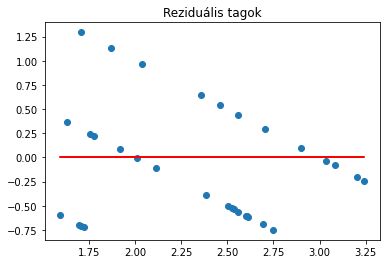

In [17]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [18]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.57

In [19]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.75
0.44


In [20]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.57 
- R2: 0.57 
- RMSE after rounding: 0.75 
- Accuracy after rounding: 0.44


### Eredmények összesítve

In [21]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'} 
- Accuracy: 0.71875
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 27, 'classifier__weights': 'distance'} 
- Accuracy: 0.71875
SVM:
- Accuracy: 0.71875
Logistic Regression:
- Accuracy: 0.65625
Naive Bayes:
- Accuracy: 0.72
Linear regression:
- RMSE: 0.57 
- R2: 0.57 
- RMSE after rounding: 0.75 
- Accuracy after rounding: 0.44


# PCA

In [22]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.56, 0.78, 0.66, 0.59, 0.62, 0.72, 0.66, 0.59, 0.59]

In [23]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.78
Precision: 0.83
Recall: 0.83


In [24]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of

In [25]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.5625,0.7500,0.7188,0.6875,0.4995,0.3112,0.6124,0.6250
1,2,0.5938,0.7812,0.6875,0.7812,0.4934,0.3379,0.6124,0.6250
2,3,0.6250,0.7188,0.6250,0.7188,0.4930,0.3978,0.5863,0.6562
3,4,0.5312,0.7188,0.6562,0.6875,0.5035,0.4046,0.5863,0.6562
4,5,0.5000,0.7500,0.5938,0.5625,0.5175,0.4232,0.6374,0.5938
5,6,0.5312,0.7812,0.6250,0.7188,0.5182,0.4000,0.5590,0.6875
6,7,0.5312,0.7812,0.6250,0.7500,0.5328,0.4182,0.5303,0.7188
7,8,0.5312,0.7500,0.6562,0.6250,0.5374,0.4592,0.5590,0.6875


# Biomérnökök

In [26]:
from imblearn.over_sampling import SMOTE



#smote = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = {2: 145, 3: 80, 1: 25})

biom = working_data.query("Szak == 'Biomérnöki'")

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = biom.drop(labels = ["Matematika A1a - Analízis", "Szak", "Matek helyes","Kognitív pont",  "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = biom["Matematika A1a - Analízis"]

#itt nem kell SMOTE
#features, label = smote.fit_resample(features, label)


X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(


# Osztályozó algoritmusok

**KNN**

In [27]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.6977777777777778, 'test_score': 0.5909090909090909}
Params:
{'classifier__n_neighbors': 18, 'classifier__weights': <function squared at 0x000001FEDA35B040>}


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.51333333 0.51333333 0.51333333 0.59777778 0.51333333 0.51333333
 0.63333333 0.63333333 0.63333333 0.61555556 0.59333333 0.59333333
 0.69555556 0.69555556 0.69555556 0.63555556 0.65555556 0.65555556
 0.56888889 0.59333333 0.63555556 0.52888889 0.52888889 0.61333333
 0.54888889 0.59111111 0.67555556 0.59333333 0.61333333 0.65555556
 0.59333333 0.57111111 0.59555556 0.57555556 0.59777778 0.59555556
 0.59555556 0.57333333 0.57555556 0.59333333 0.63333333 0.65555556
 0.63333333 0.57111111 0.57333333 0.59333333 0.65333333 0.67555556
 0.65555556 0.65555556 0.65777778 0.59555556 0.67555556 0.69777778
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        

In [28]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.8, 'test_score': 0.5909090909090909}
Params:
{'classifier__n_neighbors': 14, 'classifier__weights': <function squared at 0x000001FEDA35B040>}


In [29]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 18, 'classifier__weights': <function squared at 0x000001FEDA35B040>} 
- Accuracy: 0.5909090909090909
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 14, 'classifier__weights': <function squared at 0x000001FEDA35B040>} 
- Accuracy: 0.5909090909090909


**SVM**

In [30]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.82, 'test_score': 0.6363636363636364}
Params:
{'classifier__C': 0.4, 'classifier__kernel': 'linear'}

Accuracy: 0.64
Precision: 0.69
Recall: 0.64


**Logisztikus Regresszió**

In [31]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.7777777777777778, 'test_score': 0.5454545454545454}
Params:
{'classifier__C': 2.35, 'classifier__solver': 'sag'}

Accuracy: 0.55
Precision: 0.57
Recall: 0.55


**Naive Bayes**

In [32]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.73


In [33]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.6363636363636364 
- Logistic Regression: 0.5454545454545454 
- Naive Bayes: 0.73


**Gradient Boosting**

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.7155555555555556, 'test_score': 0.5}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.35000000000000003, 'classifier__max_depth': 4, 'classifier__n_estimators': 20}

Accuracy: 0.5
Precision: 0.55
Recall: 0.5


**Lineáris regresszió**

In [35]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.6810631883070057

In [36]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [ 2.58577580e-01  6.14949387e-01 -4.08068097e-01 -1.24241996e-01
  2.55415205e-01  1.13967564e-01 -9.00137559e+13  9.00137559e+13
 -5.06604499e-02  4.29315492e-01  1.35290476e+00  1.37630418e-01]
RMSE: 0.56


<function matplotlib.pyplot.show(close=None, block=None)>

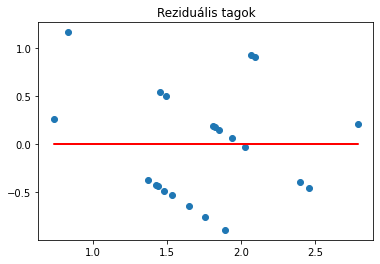

In [37]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [38]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.47

In [39]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.64
0.59


In [40]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.56 
- R2: 0.47 
- RMSE after rounding: 0.64 
- Accuracy after rounding: 0.59


### Eredmények összesítve

In [41]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 18, 'classifier__weights': <function squared at 0x000001FEDA35B040>} 
- Accuracy: 0.5909090909090909
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 14, 'classifier__weights': <function squared at 0x000001FEDA35B040>} 
- Accuracy: 0.5909090909090909
SVM:
- Accuracy: 0.6363636363636364
Logistic Regression:
- Accuracy: 0.5454545454545454
Naive Bayes:
- Accuracy: 0.73
Linear regression:
- RMSE: 0.56 
- R2: 0.47 
- RMSE after rounding: 0.64 
- Accuracy after rounding: 0.59


# PCA

In [42]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.59, 0.45, 0.91, 0.77, 0.59, 0.68, 0.55, 0.64, 0.45]

In [43]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.64
Precision: 0.61
Recall: 0.74


In [44]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of

In [45]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.4091,0.6818,0.4091,0.4545,0.5318,0.3281,0.6396,0.5909
1,2,0.6364,0.7727,0.5455,0.5455,0.4118,0.5674,0.5222,0.7273
2,3,0.6364,0.7727,0.6818,0.6818,0.4221,0.5203,0.4264,0.8182
3,4,0.6818,0.8636,0.7273,0.7273,0.4166,0.5301,0.3693,0.8636
4,5,0.6364,0.8182,0.7273,0.7727,0.4106,0.5040,0.3693,0.8636
5,6,0.5909,0.8636,0.6364,0.8182,0.3896,0.5135,0.3693,0.8636
6,7,0.6364,0.7727,0.7273,0.4091,0.5030,0.3571,0.7071,0.5000
7,8,0.7273,0.7727,0.5455,0.7273,0.4952,0.3501,0.6742,0.5455


# Modulok és Dataprep

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [47]:
working_data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/ONKUTFEL2/NYERS_2021/data_2021_SZŰKJÓ.xlsx")

**Minimális Feature Engineering**

In [48]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = working_data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
#for i, row in working_data.iterrows():
#    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
#    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
#    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
#    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [49]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [3, 4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 1
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 1]:
        working_data.at[i, "Matematika A1a - Analízis"] = 0

In [50]:
working_data['Matematika A1a - Analízis'].value_counts()

0    122
1     80
Name: Matematika A1a - Analízis, dtype: int64

# Vegyészek

In [51]:
from imblearn.over_sampling import SMOTE



#smote = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = {2: 145, 3: 80, 1: 25})

vegyesz = working_data.query("Szak == 'Vegyészmérnöki'")

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = vegyesz.drop(labels = ["Matematika A1a - Analízis", "Szak", "Matek helyes","Kognitív pont", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = vegyesz["Matematika A1a - Analízis"]

#itt nem kell SMOTE
#features, label = smote.fit_resample(features, label)


X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(


## Osztályozó algoritmusok

**KNN**

In [52]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.7761904761904762, 'test_score': 0.6875}
Params:
{'classifier__n_neighbors': 26, 'classifier__weights': 'uniform'}


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.71047619 0.71047619 0.71047619 0.61142857 0.71047619 0.71047619
 0.71047619 0.71047619 0.68285714 0.72285714 0.73809524 0.72380952
 0.73619048 0.73619048 0.68095238 0.70857143 0.75142857 0.73714286
 0.65333333 0.65333333 0.62571429 0.68095238 0.73714286 0.73714286
 0.70761905 0.70761905 0.70761905 0.69333333 0.70761905 0.70761905
 0.74857143 0.74857143 0.72190476 0.70761905 0.73619048 0.73619048
 0.68       0.68       0.69428571 0.68190476 0.69428571 0.70857143
 0.72285714 0.72190476 0.75047619 0.72285714 0.74952381 0.74952381
 0.70761905 0.70666667 0.72095238 0.70761905 0.70666667 0.72095238
 0.72095238 0.70666667 0.72095238 0.69428571 0.69333333 0.67904762
 0.70761905 0.70666667 0.70666667 0.75047619 0.68       0.68
 0.72095238 0.70761905 0.72095238 0.74857143 0.76380952 0.73619048
 0.74952381 0.72190476 0.72190476 0.77619048 0.74857143 0.

In [53]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.8495238095238096, 'test_score': 0.6875}
Params:
{'classifier__n_neighbors': 19, 'classifier__weights': 'uniform'}


In [54]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 26, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6875
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 19, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6875


**SVM**

In [55]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.8342857142857142, 'test_score': 0.65625}
Params:
{'classifier__C': 1.0, 'classifier__kernel': 'rbf'}

Accuracy: 0.66
Precision: 0.66
Recall: 0.66


**Logisztikus Regresszió**

In [56]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.7904761904761904, 'test_score': 0.71875}
Params:
{'classifier__C': 2.15, 'classifier__solver': 'sag'}

Accuracy: 0.72
Precision: 0.72
Recall: 0.72


**Naive Bayes**

In [57]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.81


In [58]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.65625 
- Logistic Regression: 0.71875 
- Naive Bayes: 0.81


**Gradient Boosting**

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.7780952380952381, 'test_score': 0.71875}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.28, 'classifier__max_depth': 4, 'classifier__n_estimators': 40}

Accuracy: 0.72
Precision: 0.74
Recall: 0.72


**Lineáris regresszió**

In [60]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.424858422453393

In [61]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [-0.13749953  0.15594944  0.04724103 -0.12925569 -0.26713237  0.45391455
 -0.19341344  0.61163434  0.42966223 -0.03153951  0.09070248]
RMSE: 0.44


<function matplotlib.pyplot.show(close=None, block=None)>

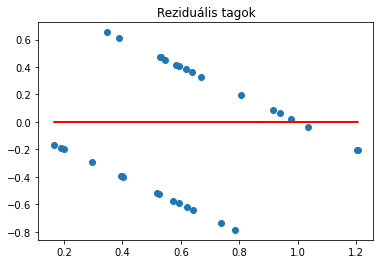

In [62]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [63]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.31

In [64]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.56
0.69


In [65]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.44 
- R2: 0.31 
- RMSE after rounding: 0.56 
- Accuracy after rounding: 0.69


### Eredmények összesítve

In [66]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 26, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6875
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 19, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6875
SVM:
- Accuracy: 0.65625
Logistic Regression:
- Accuracy: 0.71875
Naive Bayes:
- Accuracy: 0.81
Linear regression:
- RMSE: 0.44 
- R2: 0.31 
- RMSE after rounding: 0.56 
- Accuracy after rounding: 0.69


# PCA

In [67]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.5, 0.59, 0.75, 0.69, 0.72, 0.59, 0.62, 0.66, 0.81]

In [68]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.75
Precision: 0.75
Recall: 0.75


In [69]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of

In [70]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.5312,0.7812,0.8125,0.7188,0.4251,0.1996,0.4330,0.8125
1,2,0.5625,0.7812,0.7812,0.8438,0.4218,0.2147,0.4677,0.7812
2,3,0.6562,0.7188,0.7188,0.6875,0.4102,0.3348,0.5303,0.7188
3,4,0.6562,0.7188,0.6875,0.6875,0.4094,0.3365,0.5303,0.7188
4,5,0.5625,0.7188,0.7188,0.6562,0.4088,0.3326,0.5303,0.7188
5,6,0.6875,0.7188,0.7188,0.7812,0.4075,0.3282,0.5303,0.7188
6,7,0.6250,0.7500,0.8438,0.8125,0.4001,0.3449,0.4330,0.8125
7,8,0.6875,0.7500,0.7812,0.7812,0.3987,0.3867,0.4677,0.7812


# Biomérnökök

In [71]:
from imblearn.over_sampling import SMOTE



#smote = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = {2: 145, 3: 80, 1: 25})

biom = working_data.query("Szak == 'Biomérnöki'")

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = biom.drop(labels = ["Matematika A1a - Analízis", "Szak", "Matek helyes","Kognitív pont",  "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = biom["Matematika A1a - Analízis"]

#itt nem kell SMOTE
#features, label = smote.fit_resample(features, label)


X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(


# Osztályozó algoritmusok

**KNN**

In [72]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.7955555555555556, 'test_score': 0.7727272727272727}
Params:
{'classifier__n_neighbors': 1, 'classifier__weights': 'distance'}


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.44888889 0.79555556 0.79555556 0.69333333 0.79555556 0.79555556
 0.61333333 0.79555556 0.79555556 0.73555556 0.79555556 0.79555556
 0.69555556 0.79555556 0.79555556 0.75555556 0.79555556 0.79555556
 0.75555556 0.79555556 0.79555556 0.77555556 0.79555556 0.79555556
 0.75555556 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556
 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556
 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556
 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556
 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556 0.79555556
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        

In [73]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.9177777777777777, 'test_score': 0.8636363636363636}
Params:
{'classifier__n_neighbors': 3, 'classifier__weights': <function squared at 0x000001FEDA35C5E0>}


In [74]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 1, 'classifier__weights': 'distance'} 
- Accuracy: 0.7727272727272727
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 3, 'classifier__weights': <function squared at 0x000001FEDA35C5E0>} 
- Accuracy: 0.8636363636363636


**SVM**

In [75]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.8777777777777779, 'test_score': 0.9090909090909091}
Params:
{'classifier__C': 4.1000000000000005, 'classifier__kernel': 'rbf'}

Accuracy: 0.91
Precision: 0.92
Recall: 0.91


**Logisztikus Regresszió**

In [76]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.8555555555555555, 'test_score': 0.7272727272727273}
Params:
{'classifier__C': 0.05, 'classifier__solver': 'sag'}

Accuracy: 0.73
Precision: 0.77
Recall: 0.73


**Naive Bayes**

In [77]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.95


In [78]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.9090909090909091 
- Logistic Regression: 0.7272727272727273 
- Naive Bayes: 0.95


**Gradient Boosting**

In [79]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.8800000000000001, 'test_score': 0.7727272727272727}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.17, 'classifier__max_depth': 3, 'classifier__n_estimators': 5}

Accuracy: 0.77
Precision: 0.73
Recall: 0.77


**Lineáris regresszió**

In [80]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.5965691151297507

In [81]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [-7.91861463e-02  1.91659478e-01  3.15146360e-01 -1.61555405e-01
  2.47917987e-01 -2.20215705e-01 -4.04145234e-04 -4.04145234e-04
  2.45491805e-01 -3.05926524e-02  7.85025789e-01  2.25361714e-01]
RMSE: 0.31


<function matplotlib.pyplot.show(close=None, block=None)>

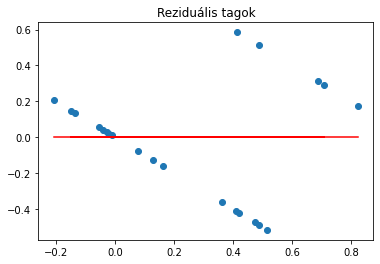

In [82]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [83]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.53

In [84]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.37
0.86


In [85]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.31 
- R2: 0.53 
- RMSE after rounding: 0.37 
- Accuracy after rounding: 0.86


### Eredmények összesítve

In [86]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 1, 'classifier__weights': 'distance'} 
- Accuracy: 0.7727272727272727
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 3, 'classifier__weights': <function squared at 0x000001FEDA35C5E0>} 
- Accuracy: 0.8636363636363636
SVM:
- Accuracy: 0.9090909090909091
Logistic Regression:
- Accuracy: 0.7272727272727273
Naive Bayes:
- Accuracy: 0.95
Linear regression:
- RMSE: 0.31 
- R2: 0.53 
- RMSE after rounding: 0.37 
- Accuracy after rounding: 0.86


# PCA

In [87]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.86, 0.91, 0.91, 0.91, 0.95, 0.82, 0.86, 0.86, 0.82]

In [88]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.77
Precision: 0.68
Recall: 0.76


In [89]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of

In [90]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.9091,0.9091,0.5455,0.6364,0.3968,0.4155,0.3015,0.9091
1,2,0.8636,0.7727,0.6364,0.8182,0.3695,0.5100,0.3693,0.8636
2,3,0.9091,0.8182,0.7273,0.6364,0.3551,0.4727,0.3015,0.9091
3,4,0.9091,0.8182,0.7727,0.6364,0.3430,0.4637,0.2132,0.9545
4,5,0.9091,0.8182,0.7273,0.6818,0.3511,0.5184,0.3693,0.8636
5,6,0.9545,0.8182,0.6818,0.7273,0.3521,0.5262,0.3693,0.8636
6,7,0.8636,0.8636,0.7727,0.7727,0.3851,0.4783,0.3693,0.8636
7,8,0.8182,0.8636,0.7727,0.7727,0.3636,0.4998,0.4264,0.8182


# Legjobb modellek

In [ ]:
# A Naive Bayes mindegyiknél nagyon jó volt, főleg 6-7 főkomponenssel

# 3 csoport Vegyész: 6-7 PCA-s SVM és Linreg

# 3 csoport Bio: 5-6 PCA-s linreg

#--------------------------

# 2 csoport Vegyész: 6-7 PCA-s Logreg és Linreg

# 2 csoport Bio: 4-es PCA linreg
